**1 тестовый пример. Сопло Лаваля**

In [1]:
import numpy as np

def NormMatrix(a):
    res = 0

    '''for i in range(len(a)):
        for j in range(len(a[0])):
            res += a[i][j]**2'''

    for i in range(len(a)):
        sum = 0
        for j in range(len(a[0])):
            sum += abs(a[i][j])
        res = max(res, sum)

    return res

def NormVector(a):
    res = 0

    for i in range(len(a)):
        res += a[i]**4

    return res**(0.25)

def MatrixDifference(a,b):
    res = np.empty(len(a), dtype=float)

    for i in range(len(a)):
        res[i] = a[i] - b[i]

    return res

def MatrixSum(a, b):
    res = np.empty(len(a), dtype=float)

    for i in range(len(a)):
        res[i] = a[i] + b[i]

    return res

def MatrixMultiplication(alpha, x, beta):
    res = np.empty(len(x), dtype=float)
    res = np.copy(x)

    for i in range(len(x)):
        res[i] = beta[i]
        for j in range(i):
            res[i] += alpha[i][j]*res[j]
        for j in range(i, len(x)):
            res[i] += alpha[i][j]*x[j]

    return res

def SimpleIterationsMethod(matrix, b, eps):
    size = len(matrix)

    alpha = np.zeros_like(matrix, dtype=float)
    beta = np.zeros_like(b, dtype=float)

    for i in range(size):
        for j in range(size):
            if i==j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -matrix[i][j]/matrix[i][i]
        #beta[0][i] = b[0][i]/matrix[i][i]
        beta[i] = b[i]/matrix[i][i]

    iterations_count = 0
    current_ans = np.copy(beta)
    normAlpha = NormMatrix(alpha)
    current_eps = 0

    while True:
        prev_ans = np.copy(current_ans)

        for i in range(size):
            res = beta[i]
            for j in range(size):
                res+=alpha[i][j]*prev_ans[j]
            current_ans[i] = res

        iterations_count+=1

        if normAlpha < 1:
            current_eps = (normAlpha/(1-normAlpha))*NormVector(MatrixDifference(current_ans, prev_ans))
        elif normAlpha == 1:
            current_eps = NormVector(MatrixDifference(current_ans, prev_ans))

        if current_eps <= eps:
            return current_ans, iterations_count

def ZeidelMethod(matrix, b, eps):
    size = len(matrix)

    alpha = np.zeros_like(matrix, dtype=float)
    beta = np.zeros_like(b, dtype=float)

    for i in range(size):
        for j in range(size):
            if i == j:
                alpha[i][j] = 0
            else:
                alpha[i][j] = -matrix[i][j] / matrix[i][i]
        # beta[0][i] = b[0][i]/matrix[i][i]
        beta[i] = b[i] / matrix[i][i]

    iterations_count = 0
    current_ans = np.copy(beta)
    normAlpha = NormMatrix(alpha)
    current_eps = 0

    while True:
        prev_ans = np.copy(current_ans)
        current_ans = MatrixMultiplication(alpha, prev_ans, beta)
        iterations_count += 1

        if normAlpha < 1:
            current_eps = (normAlpha/(1-normAlpha))*NormVector(MatrixDifference(current_ans, prev_ans))
        elif normAlpha == 1:
            current_eps = NormVector(MatrixDifference(current_ans, prev_ans))

        if current_eps <= eps:
            return current_ans, iterations_count

1.1768292682926829

Средние параметры:

Середина (x=0.500):
 <M> = 2.162716856624813
 <p> = 78671.55537564501 Па
 <T> = 279.0004225183971 К
 <rho> = 0.9824842494444314 кг/м³

Выход (x=1.000):
 <M> = 2.2958325387479475
 <p> = 63916.814499111555 Па
 <T> = 262.8767008364385 К
 <rho> = 0.8471643838090008 кг/м³


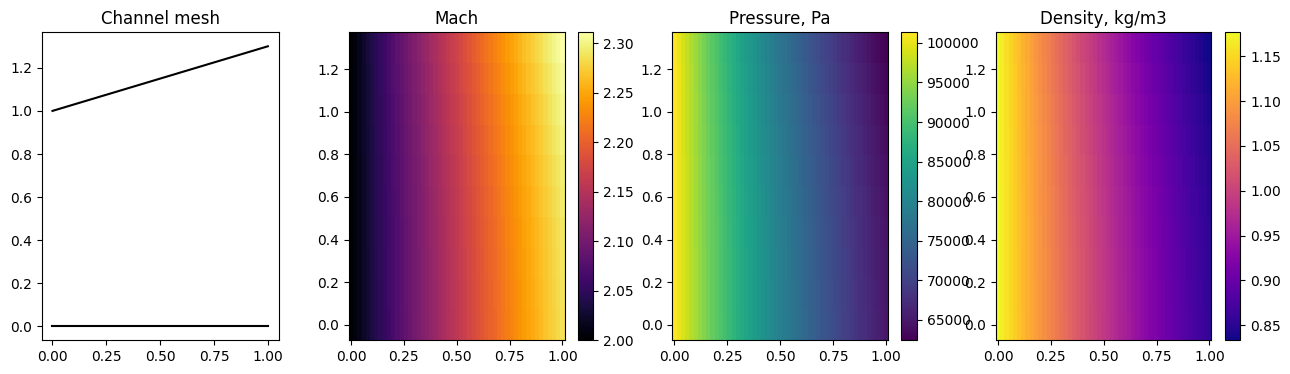

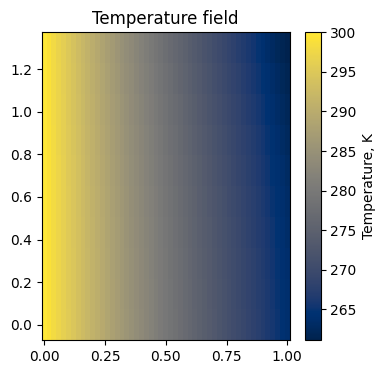

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# 1) Параметры газа и канала
# ------------------------
gamma, R = 1.4, 287.0
p_ref, T_ref, M_ref = 101325.0, 300.0, 2.0
a_ref = np.sqrt(gamma * R * T_ref)
w_ref = M_ref * a_ref
print(p_ref / (R * T_ref))

L, h0, h1 = 1.0, 1.0, 1.3
def top_wall(x):
    return h0 + (h1 - h0) * (x / L)
#alpha = np.deg2rad(15)
alpha = np.arctan((h1 - h0)/L)

'''gamma, R = 1.4, 287.1
p_ref, T_ref, M_ref = 1.215e6, 933.3, 1.0
a_ref = np.sqrt(gamma * R * T_ref)
w_ref = M_ref * a_ref

L, h0, h1 = 0.3552, 0.07570, 0.1441
def top_wall(x):
  return h0 + (h1 - h0) * (x / L)
alpha = np.deg2rad(5.5)'''


Nx, Ny = 50, 10
x = np.linspace(0, L, Nx+1)
y0 = np.linspace(0, top_wall(0), Ny)
theta0 = np.linspace(0, alpha, Ny)

u   = np.zeros((Nx+1, Ny))
v   = np.zeros((Nx+1, Ny))
p   = np.zeros((Nx+1, Ny))
rho = np.zeros((Nx+1, Ny))

u[0,:]   = w_ref * np.cos(theta0)
v[0,:]   = w_ref * np.sin(theta0)
p[0,:]   = p_ref
rho[0,:] = p_ref / (R * T_ref)


eps = 1e-8

'''def sound_speed(p_, rho_):
    return np.sqrt(gamma * p_ / np.maximum(rho_, eps))'''
def sound_speed(p_, rho_):

    p_clamped   = np.maximum(p_,   eps)
    rho_clamped = np.maximum(rho_, eps)
    return np.sqrt(gamma * p_clamped / rho_clamped)

def enthalpy(p_, rho_):
    return gamma/(gamma-1) * p_ / np.maximum(rho_, eps)

def interp_y(field, yg, y_val):
    j = np.searchsorted(yg, y_val) - 1
    j = np.clip(j, 0, len(yg)-2)
    yj, yj1 = yg[j], yg[j+1]
    w1 = (yj1 - y_val) / (yj1 - yj + eps)
    w2 = (y_val - yj)   / (yj1 - yj + eps)
    return w1 * field[j] + w2 * field[j+1]

# Function to compute residuals F1..F4 at U = [u3,v3,p3,rho3]
def compute_F(U, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3):
    u3, v3, p3, rho3 = U

    theta3 = np.arctan2(v3, u3)
    w3 = np.hypot(u3, v3) + eps
    a3 = sound_speed(p3, rho3)
    mu3 = np.arcsin(np.clip(a3 / w3, -1.0, 1.0))

    lam_p = np.tan(theta3 + mu3)
    lam_m = np.tan(theta3 - mu3)
    lam_0 = v3 / (u3 + eps)

    y1 = y3 - lam_p * dx
    y2 = y3 - lam_m * dx
    y4 = y3 - lam_0 * dx

    u1, v1 = interp_y(u_k_layer,   yg, y1), interp_y(v_k_layer,   yg, y1)
    p1, rho1 = interp_y(p_k_layer, yg, y1), interp_y(rho_k_layer, yg, y1)
    u2, v2 = interp_y(u_k_layer,   yg, y2), interp_y(v_k_layer,   yg, y2)
    p2, rho2 = interp_y(p_k_layer, yg, y2), interp_y(rho_k_layer, yg, y2)
    u4, v4 = interp_y(u_k_layer,   yg, y4), interp_y(v_k_layer,   yg, y4)
    p4, rho4 = interp_y(p_k_layer, yg, y4), interp_y(rho_k_layer, yg, y4)

    a1, a2, a4 = sound_speed(p1, rho1), sound_speed(p2, rho2), sound_speed(p4, rho4)
    w1, w2, w4 = np.hypot(u1, v1)+eps, np.hypot(u2, v2)+eps, np.hypot(u4, v4)+eps
    mu1 = np.arcsin(np.clip(a1/w1, -1.0, 1.0))
    mu2 = np.arcsin(np.clip(a2/w2, -1.0, 1.0))
    cot1 = np.cos(mu1) / (np.sin(mu1) + eps)
    cot2 = np.cos(mu2) / (np.sin(mu2) + eps)

    F1 = theta3 - np.arctan2(v1, u1) + (1/(rho1*w1**2+eps))*cot1*(p3-p1)
    F2 = theta3 - np.arctan2(v2, u2) - (1/(rho2*w2**2+eps))*cot2*(p3-p2)
    F3 = p3 - p4 - a4**2*(rho3-rho4)
    F4 = enthalpy(p3,rho3) - enthalpy(p4,rho4) + 0.5*((u3**2+v3**2)-(u4**2+v4**2))
    return np.array([F1, F2, F3, F4])

#  Основной цикл с методом Ньютона

max_iter = 10
tol = 1e-6
delta = 1e-6

for k in range(Nx):
    dx = x[k+1] - x[k]
    yg  = np.linspace(0, top_wall(x[k]),   Ny)
    yg1 = np.linspace(0, top_wall(x[k+1]), Ny)

    for j in range(Ny):
        y3 = yg1[j]

        u_k_layer = u[k,:]; v_k_layer = v[k,:]
        p_k_layer = p[k,:]; rho_k_layer = rho[k,:]

        U = np.array([u[k,j], v[k,j], p[k,j], rho[k,j]])

        # Newton iterations
        for n in range(max_iter):
            F = compute_F(U, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3)

            J = np.zeros((4,4))
            for i in range(4):
                dU = np.zeros(4); dU[i] = delta
                J[:,i] = (compute_F(U + dU, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3) - F) / delta

            try:
                dU = np.linalg.solve(J, -F)
            except np.linalg.LinAlgError:

                J_reg = J + np.eye(4)*1e-6
                try:
                    dU = np.linalg.solve(J_reg, -F)
                except np.linalg.LinAlgError:

                    dU = -np.linalg.pinv(J).dot(F)

            U_new = U + dU
            U_new[2] = max(U_new[2], eps)
            U_new[3] = max(U_new[3], eps)
            if np.linalg.norm(dU, np.inf) < tol:
                U = U_new
                break
            U = U_new

        u[k+1,j], v[k+1,j], p[k+1,j], rho[k+1,j] = U


T   = p / (rho * R)
a   = np.sqrt(gamma * p / rho)
M   = np.hypot(u, v) / a
w   = np.hypot(u, v)

# Средние по слою
mid_k  = Nx//2; exit_k = Nx
print("\nСредние параметры:")
for name, k in [("Середина", mid_k), ("Выход", exit_k)]:
    print(f"\n{name} (x={x[k]:.3f}):")
    print(" <M> =", np.mean(M[k,:]))
    print(" <p> =", np.mean(p[k,:]), "Па")
    print(" <T> =", np.mean(T[k,:]), "К")
    print(" <rho> =", np.mean(rho[k,:]), "кг/м³")



fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(16,4))

ax1.plot(x, np.zeros_like(x),'k-')
ax1.plot(x, top_wall(x),'k-')
ax1.set_title('Channel mesh')
ax1.set_aspect('equal')
# Mach
c1 = ax2.pcolormesh(x, yg1, M.T, shading='auto', cmap='inferno'); fig.colorbar(c1,ax=ax2); ax2.set_title('Mach')
# Pressure
c2 = ax3.pcolormesh(x, yg1, p.T, shading='auto', cmap='viridis'); fig.colorbar(c2,ax=ax3); ax3.set_title('Pressure, Pa')
# Density
c3 = ax4.pcolormesh(x, yg1, rho.T, shading='auto', cmap='plasma'); fig.colorbar(c3,ax=ax4); ax4.set_title('Density, kg/m3')
# Temperature
plt.figure(figsize=(4,4))
plt.pcolormesh(x, yg1, T.T, shading='auto', cmap='cividis')
plt.colorbar(label='Temperature, K'); plt.title('Temperature field')
plt.show()

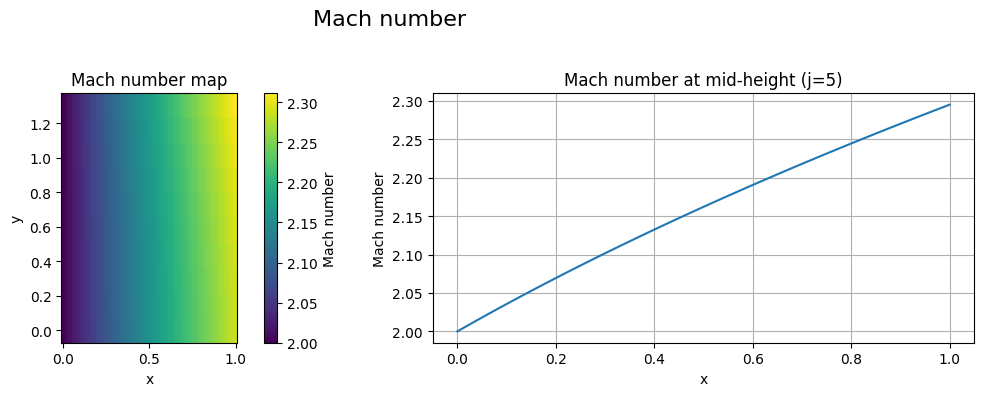

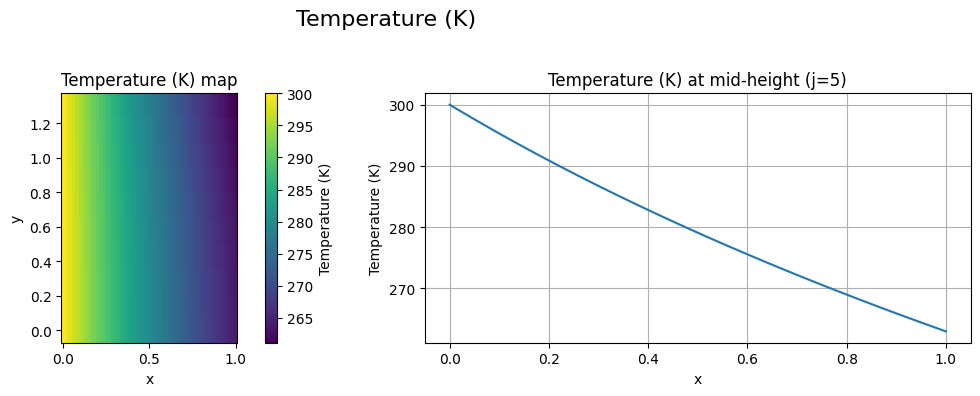

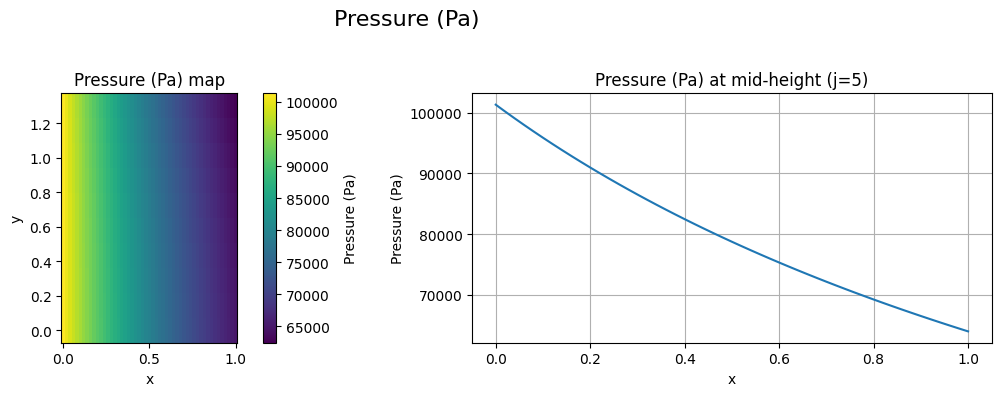

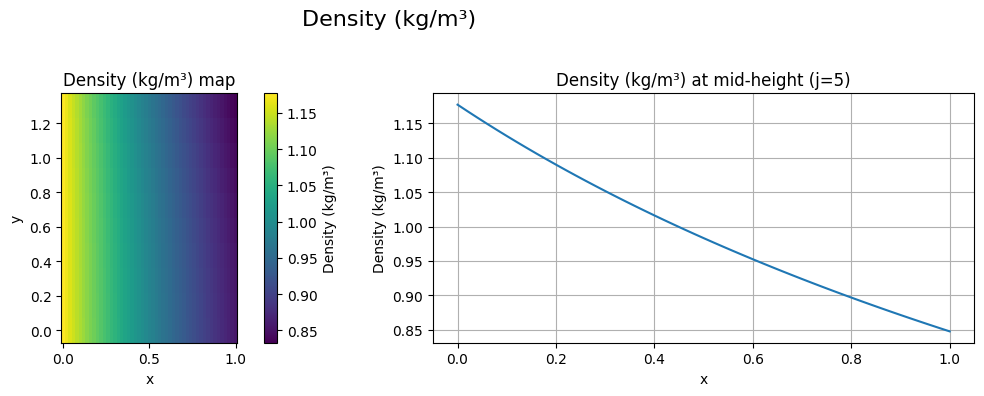

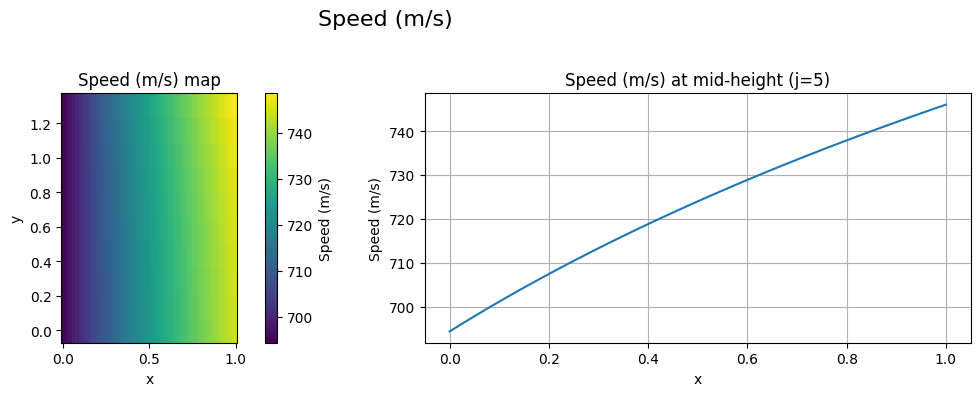

In [ ]:
fields = {
    "Mach number": (M, "M"),
    "Temperature (K)": (T, "T"),
    "Pressure (Pa)": (p, "p"),
    "Density (kg/m³)": (rho, "rho"),
    "Speed (m/s)": (w, "w")
}

j_mid = Ny // 2

for title, (field, var) in fields.items():
    # Compute midline distribution
    mid_dist = field[:, j_mid]

    fig, (ax_map, ax_line) = plt.subplots(1, 2, figsize=(12, 4))
    # Map
    c = ax_map.pcolormesh(x, yg1, field.T, shading='auto', cmap='viridis')
    fig.colorbar(c, ax=ax_map, label=title)
    ax_map.set_title(f"{title} map")
    ax_map.set_xlabel("x")
    ax_map.set_ylabel("y")
    ax_map.set_aspect('equal')

    # Line plot
    ax_line.plot(x, mid_dist)
    ax_line.set_title(f"{title} at mid-height (j={j_mid})")
    ax_line.set_xlabel("x")
    ax_line.set_ylabel(title)
    ax_line.grid(True)

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**2 пример. Течение от источника**

In [3]:
import math

def analytical_point_source(r: float,
                            r_star: float = 1.0,
                            p_star: float = 101325.0,
                            rho_star: float = 1.0,
                            kappa: float = 1.4,
                            tol: float = 1e-10,
                            max_iter: int = 100):

   # Возвращает (w, M, p, rho) для r ≥ r_star

    if r < r_star:
        raise ValueError("r должен быть ≥ r_star")


    a_star = math.sqrt(kappa * p_star / rho_star)
    target = r / r_star

    def F(w):
        A = ( (kappa+1)/2
              - (kappa-1)/2 * (w**2 / a_star**2) )
        return 1.0 / ( A**(1.0/(kappa-1)) * (w/a_star) ) - target

    w_lo = a_star
    w_hi = a_star * math.sqrt((kappa+1)/(kappa-1)) * (1 - 1e-12)


    f_lo = F(w_lo)
    f_hi = F(w_hi)
    if f_lo * f_hi > 0:
        raise RuntimeError("Корень не лежит в физическом диапазоне")

    for _ in range(max_iter):
        w_mid = 0.5*(w_lo + w_hi)
        f_mid = F(w_mid)
        if abs(f_mid) < tol or (w_hi - w_lo)/2 < tol:
            w = w_mid
            break
        if f_mid * f_lo < 0:
            w_hi = w_mid
        else:
            w_lo, f_lo = w_mid, f_mid
    else:
        raise RuntimeError("Бисекция не сошлась")


    A = ( (kappa+1)/2
          - (kappa-1)/2 * (w**2 / a_star**2) )
    a   = a_star * math.sqrt(A)
    M   = w / a
    rho = rho_star * A**(1.0/(kappa-1))
    p   = rho * a**2 / kappa

    return w, M, p, rho


if __name__ == "__main__":
    for r in [1.0, 1.5, 2.0, 5.0]:
        w, M, p, rho = analytical_point_source(r)
        print(f"r={r:.1f} → w={w:7.2f} m/s, M={M:5.3f}, "
              f"p={p:8.1f} Pa, rho={rho:6.4f} kg/m³")


r=1.0 → w= 922.57 m/s, M=1530414.480, p=     0.0 Pa, rho=0.0000 kg/m³
r=1.5 → w= 588.87 m/s, M=1.854, p= 30721.9 Pa, rho=0.4264 kg/m³
r=2.0 → w= 646.61 m/s, M=2.197, p= 18016.4 Pa, rho=0.2912 kg/m³
r=5.0 → w= 754.26 m/s, M=3.175, p=  4026.4 Pa, rho=0.0999 kg/m³


1.0

Средние параметры:

Середина (x=1.500):
 <M> = 2.7850881064494173
 <p> = 20363.722405810357 Па
 <T> = 218.92762522677532 К
 <rho> = 0.3201580676991137 кг/м³

Выход (x=3.000):
 <M> = 3.297389409974598
 <p> = 9793.399337468287 Па
 <T> = 176.4306335767883 К
 <rho> = 0.18936406507555725 кг/м³


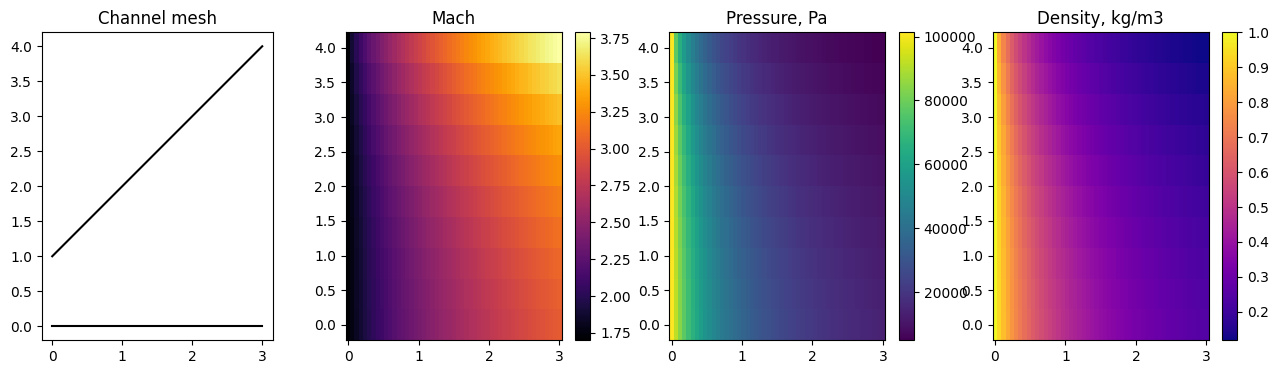

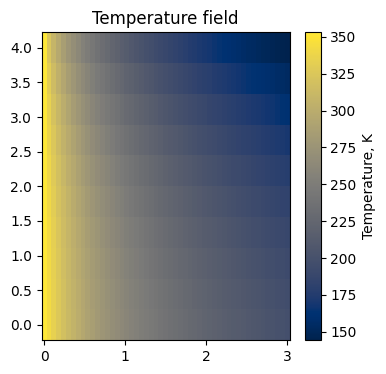

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# 1) Параметры газа и канала
# ------------------------
gamma, R = 1.4, 287.0
p_ref, ro_ref, M_ref = 101325.0, 1.0, 1.7
T_ref = p_ref / (R * ro_ref)
a_ref = np.sqrt(gamma * R * T_ref)
w_ref = M_ref * a_ref
print(p_ref / (R * T_ref))

L, h0, h1 = 3.0, 1.0, 4.0
def top_wall(x):
    return h0 + (h1 - h0) * (x / L)
#alpha = np.deg2rad(15)
alpha = np.arctan((h1 - h0)/L)

'''gamma, R = 1.4, 287.1
p_ref, T_ref, M_ref = 1.215e6, 933.3, 1.0
a_ref = np.sqrt(gamma * R * T_ref)
w_ref = M_ref * a_ref

L, h0, h1 = 0.3552, 0.07570, 0.1441
def top_wall(x):
  return h0 + (h1 - h0) * (x / L)
alpha = np.deg2rad(5.5)'''


Nx, Ny = 50, 10
x = np.linspace(0, L, Nx+1)
y0 = np.linspace(0, top_wall(0), Ny)
theta0 = np.linspace(0, alpha, Ny)


u   = np.zeros((Nx+1, Ny))
v   = np.zeros((Nx+1, Ny))
p   = np.zeros((Nx+1, Ny))
rho = np.zeros((Nx+1, Ny))

u[0,:]   = w_ref * np.cos(theta0)
v[0,:]   = w_ref * np.sin(theta0)
p[0,:]   = p_ref
rho[0,:] = p_ref / (R * T_ref)


eps = 1e-8

'''def sound_speed(p_, rho_):
    return np.sqrt(gamma * p_ / np.maximum(rho_, eps))'''
def sound_speed(p_, rho_):

    p_clamped   = np.maximum(p_,   eps)
    rho_clamped = np.maximum(rho_, eps)
    return np.sqrt(gamma * p_clamped / rho_clamped)

def enthalpy(p_, rho_):
    return gamma/(gamma-1) * p_ / np.maximum(rho_, eps)

def interp_y(field, yg, y_val):
    j = np.searchsorted(yg, y_val) - 1
    j = np.clip(j, 0, len(yg)-2)
    yj, yj1 = yg[j], yg[j+1]
    w1 = (yj1 - y_val) / (yj1 - yj + eps)
    w2 = (y_val - yj)   / (yj1 - yj + eps)
    return w1 * field[j] + w2 * field[j+1]


def compute_F(U, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3):
    u3, v3, p3, rho3 = U

    theta3 = np.arctan2(v3, u3)
    w3 = np.hypot(u3, v3) + eps
    a3 = sound_speed(p3, rho3)
    mu3 = np.arcsin(np.clip(a3 / w3, -1.0, 1.0))

    lam_p = np.tan(theta3 + mu3)
    lam_m = np.tan(theta3 - mu3)
    lam_0 = v3 / (u3 + eps)

    y1 = y3 - lam_p * dx
    y2 = y3 - lam_m * dx
    y4 = y3 - lam_0 * dx

    u1, v1 = interp_y(u_k_layer,   yg, y1), interp_y(v_k_layer,   yg, y1)
    p1, rho1 = interp_y(p_k_layer, yg, y1), interp_y(rho_k_layer, yg, y1)
    u2, v2 = interp_y(u_k_layer,   yg, y2), interp_y(v_k_layer,   yg, y2)
    p2, rho2 = interp_y(p_k_layer, yg, y2), interp_y(rho_k_layer, yg, y2)
    u4, v4 = interp_y(u_k_layer,   yg, y4), interp_y(v_k_layer,   yg, y4)
    p4, rho4 = interp_y(p_k_layer, yg, y4), interp_y(rho_k_layer, yg, y4)

    a1, a2, a4 = sound_speed(p1, rho1), sound_speed(p2, rho2), sound_speed(p4, rho4)
    w1, w2, w4 = np.hypot(u1, v1)+eps, np.hypot(u2, v2)+eps, np.hypot(u4, v4)+eps
    mu1 = np.arcsin(np.clip(a1/w1, -1.0, 1.0))
    mu2 = np.arcsin(np.clip(a2/w2, -1.0, 1.0))
    cot1 = np.cos(mu1) / (np.sin(mu1) + eps)
    cot2 = np.cos(mu2) / (np.sin(mu2) + eps)

    F1 = theta3 - np.arctan2(v1, u1) + (1/(rho1*w1**2+eps))*cot1*(p3-p1)
    F2 = theta3 - np.arctan2(v2, u2) - (1/(rho2*w2**2+eps))*cot2*(p3-p2)
    F3 = p3 - p4 - a4**2*(rho3-rho4)
    F4 = enthalpy(p3,rho3) - enthalpy(p4,rho4) + 0.5*((u3**2+v3**2)-(u4**2+v4**2))
    return np.array([F1, F2, F3, F4])


max_iter = 10
tol = 1e-6
delta = 1e-6

for k in range(Nx):
    dx = x[k+1] - x[k]
    yg  = np.linspace(0, top_wall(x[k]),   Ny)
    yg1 = np.linspace(0, top_wall(x[k+1]), Ny)

    for j in range(Ny):
        y3 = yg1[j]

        u_k_layer = u[k,:]; v_k_layer = v[k,:]
        p_k_layer = p[k,:]; rho_k_layer = rho[k,:]

        U = np.array([u[k,j], v[k,j], p[k,j], rho[k,j]])

        # Newton iterations
        for n in range(max_iter):
            F = compute_F(U, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3)

            J = np.zeros((4,4))
            for i in range(4):
                dU = np.zeros(4); dU[i] = delta
                J[:,i] = (compute_F(U + dU, u_k_layer, v_k_layer, p_k_layer, rho_k_layer, yg, dx, y3) - F) / delta

            try:
                dU = np.linalg.solve(J, -F)
            except np.linalg.LinAlgError:

                J_reg = J + np.eye(4)*1e-6
                try:
                    dU = np.linalg.solve(J_reg, -F)
                except np.linalg.LinAlgError:

                    dU = -np.linalg.pinv(J).dot(F)
            #dU = np.linalg.solve(J, -F)
            #dU, _ = ZeidelMethod(J, -F, tol)
            U_new = U + dU
            U_new[2] = max(U_new[2], eps)
            U_new[3] = max(U_new[3], eps)
            if np.linalg.norm(dU, np.inf) < tol:
                U = U_new
                break
            U = U_new


        u[k+1,j], v[k+1,j], p[k+1,j], rho[k+1,j] = U


T   = p / (rho * R)
a   = np.sqrt(gamma * p / rho)
M   = np.hypot(u, v) / a
w   = np.hypot(u, v)

# Средние по слою
mid_k  = Nx//2; exit_k = Nx
print("\nСредние параметры:")
for name, k in [("Середина", mid_k), ("Выход", exit_k)]:
    print(f"\n{name} (x={x[k]:.3f}):")
    print(" <M> =", np.mean(M[k,:]))
    print(" <p> =", np.mean(p[k,:]), "Па")
    print(" <T> =", np.mean(T[k,:]), "К")
    print(" <rho> =", np.mean(rho[k,:]), "кг/м³")


fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(16,4))

ax1.plot(x, np.zeros_like(x),'k-')
ax1.plot(x, top_wall(x),'k-')
ax1.set_title('Channel mesh')
ax1.set_aspect('equal')
# Mach
c1 = ax2.pcolormesh(x, yg1, M.T, shading='auto', cmap='inferno'); fig.colorbar(c1,ax=ax2); ax2.set_title('Mach')
# Pressure
c2 = ax3.pcolormesh(x, yg1, p.T, shading='auto', cmap='viridis'); fig.colorbar(c2,ax=ax3); ax3.set_title('Pressure, Pa')
# Density
c3 = ax4.pcolormesh(x, yg1, rho.T, shading='auto', cmap='plasma'); fig.colorbar(c3,ax=ax4); ax4.set_title('Density, kg/m3')
# Temperature
plt.figure(figsize=(4,4))
plt.pcolormesh(x, yg1, T.T, shading='auto', cmap='cividis')
plt.colorbar(label='Temperature, K'); plt.title('Temperature field')
plt.show()

In [5]:
# 1) Задаём декартову сетку, совпадающую с формой u,v,p,rho:

X, Y = np.meshgrid(x, yg1, indexing='ij')




r_target = 3.0
dr = x[1] - x[0]                   # радиальный шаг
mask = np.abs(np.sqrt(X**2 + Y**2) - r_target) < dr/2

# 3) Усредняем по этим точкам:
u_r = np.hypot(u, v)
M_sim = u_r / np.sqrt(gamma * p / rho)

u_r_avg = np.mean(u_r[mask])
M_avg   = np.mean(M_sim[mask])
p_avg   = np.mean(p[mask])
rho_avg = np.mean(rho[mask])

# 4) Аналитика:
w_an, M_an, p_an, rho_an = analytical_point_source(r_target)
w_an = 817.411
M_an = 2.868
p_an = 14865
rho_an = 0.2678


# 5) Сравнение:
print(f"r = {r_target:.2f} м:")
print(f"  числ: w̄={u_r_avg:.3f}, M̄={M_avg:.3f}, p̄={p_avg:.1f}, rhō={rho_avg:.4f}")
print(f"  анал: w ={w_an   :.3f}, M ={M_an   :.3f}, p ={p_an   :.1f}, rho={rho_an   :.4f}")
err_w   = (u_r_avg   - w_an)   / (w_an)   * 100
err_M   = (M_avg   - M_an)   / M_an   * 100
err_p   = (p_avg   - p_an)   / p_an   * 100
err_rho = (rho_avg - rho_an) / rho_an * 100

# вывод строки
print(f"{r_target:5.1f} | "
      f"{u_r_avg:8.3f} {w_an:8.3f} {err_w:6.2f} | "
      f"{M_avg:6.3f} {M_an:6.3f} {err_M:6.2f} | "
      f"{p_avg:9.1f} {p_an:9.1f} {err_p:6.2f} | "
      f"{rho_avg:8.4f} {rho_an:8.4f} {err_rho:6.2f}")

r = 3.00 м:
  числ: w̄=842.630, M̄=2.956, p̄=15325.0, rhō=0.2619
  анал: w =817.411, M =2.868, p =14865.0, rho=0.2678
  3.0 |  842.630  817.411   3.09 |  2.956  2.868   3.07 |   15325.0   14865.0   3.09 |   0.2619   0.2678  -2.21


In [ ]:
r_targets = [1.5, 2.0, 2.5, 3.0, 5.0]


print(f"{'r':>5} | {'w_sim':>8} {'w_an':>8} {'Δw%':>6} | "
      f"{'M_sim':>6} {'M_an':>6} {'ΔM%':>6} | "
      f"{'p_sim':>9} {'p_an':>9} {'Δp%':>6} | "
      f"{'rho_sim':>8} {'rho_an':>8} {'Δρ%':>6}")
print("-"*85)


for r_t in r_targets:

    mask = np.abs(np.sqrt(X**2 + Y**2) - r_t) < dr/2

    # численные средние
    w_avg   = np.mean(u_r[mask])
    M_avg   = np.mean(M_sim[mask])
    p_avg   = np.mean(p[mask])
    rho_avg = np.mean(rho[mask])

    # аналитические значения
    w_an, M_an, p_an, rho_an = analytical_point_source(r_t)

    # относительные ошибки в %
    err_w   = (w_avg   - w_an)   / w_an   * 100
    err_M   = (M_avg   - M_an)   / M_an   * 100
    err_p   = (p_avg   - p_an)   / p_an   * 100
    err_rho = (rho_avg - rho_an) / rho_an * 100

    # вывод строки
    print(f"{r_t:5.1f} | "
          f"{w_avg:8.3f} {w_an:8.3f} {err_w:6.2f} | "
          f"{M_avg:6.3f} {M_an:6.3f} {err_M:6.2f} | "
          f"{p_avg:9.1f} {p_an:9.1f} {err_p:6.2f} | "
          f"{rho_avg:8.4f} {rho_an:8.4f} {err_rho:6.2f}")

    r |    w_sim     w_an    Δw% |  M_sim   M_an    ΔM% |     p_sim      p_an    Δp% |  rho_sim   rho_an    Δρ%
-------------------------------------------------------------------------------------
  1.5 |  779.308  588.874  32.34 |  2.444  1.854  31.82 |   33555.6   30721.9   9.22 |   0.4554   0.4264   6.81
  2.0 |  807.029  646.609  24.81 |  2.647  2.197  20.49 |   24541.9   18016.4  36.22 |   0.3649   0.2912  25.29
  2.5 |  822.615  680.509  20.88 |  2.776  2.443  13.65 |   20185.9   12272.3  64.48 |   0.3179   0.2214  43.62
  3.0 |  842.630  703.695  19.74 |  2.956  2.637  12.08 |   15325.0    9071.9  68.93 |   0.2619   0.1784  46.78
  5.0 |  912.088  754.262  20.92 |  3.789  3.175  19.35 |    4908.3    4026.4  21.90 |   0.1186   0.0999  18.74
